<a href="https://colab.research.google.com/github/Quan-kas/IbagueCovid19/blob/main/AnalisisSemanaIbagueCovid19_0135.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-8htfe5rg
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-8htfe5rg
  Created wheel for covid19-inference: filename=covid19_inference-0.2.0-cp37-none-any.whl size=112284 sha256=54b9859a1ffeea38d241d58fd750cf38b72953ddf691ce7ffbbfe3fc0c9aafcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ktu4_8hf/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


In [ ]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

## ***Importe de datos***

In [ ]:
data_begin = datetime.datetime(2021,2,1)  # For the date filter
data_end = datetime.datetime(2021, 4,30)
y = np.array([71,407,90,140,105,137,72,67,121,128,72,37,51,69,42,29,14,37,61,81,34,10,11,10,22,34,13,29,42,118,35,27,28,24,42,24,29,19,36,24,26,15,16,9,19,25,6,14,39,33,46,15,30,27,15,37,12,21,13,37,48,28,11,83,60,20,47,32,31,52,48,84,35,31,72,71,71,114,77,54,43,89,128,32,104,115,110,57,96])
new_cases_obs = pd.Series(y)

In [ ]:
new_cases_obs

0      71
1     407
2      90
3     140
4     105
     ... 
84    104
85    115
86    110
87     57
88     96
Length: 89, dtype: int64

### ***Construir Modelo***

In [ ]:
prior_date_strong_dist_begin = datetime.datetime(2021, 2, 1)
change_points = [
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.135,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
]
print(f"Añado posibles puntos de cambio:")
for i, day in enumerate(pd.date_range(start=datetime.datetime(2021, 2,7), end=datetime.datetime(2021, 4,25))):
    if day.weekday() == 6 and (datetime.datetime.today() - day).days > 9:
        print(f"\t{day}")

        # Distribuciones a priori
        change_points.append(
            dict(  # un posible punto de cambio cada domingo
                pr_mean_date_transient=day,
                pr_sigma_date_transient=1.5,
                pr_sigma_lambda=0.2,  #comparacion con el punto inicial
                relative_to_previous=True,
                pr_factor_to_previous=1,
            )
        )

Añado posibles puntos de cambio:
	2021-02-07 00:00:00
	2021-02-14 00:00:00
	2021-02-21 00:00:00
	2021-02-28 00:00:00
	2021-03-07 00:00:00
	2021-03-14 00:00:00
	2021-03-21 00:00:00
	2021-03-28 00:00:00
	2021-04-04 00:00:00
	2021-04-11 00:00:00
	2021-04-18 00:00:00
	2021-04-25 00:00:00


In [ ]:
# Número de días que la simulación comienza antes que los datos.
# Debe ser significativamente mayor que el retraso esperado para que siempre se ajuste al mismo número de puntos de datos.
diff_data_sim = 16
# Número de días en el futuro (después de date_end_data) para pronosticar casos
num_days_forecast = 8
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=data_begin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=49e6,
)
# Mediana de la anterior para el retraso en la notificación de casos, asumimos 10 días
pr_delay = 10
with cov19.model.Cov19Model(**params_model) as this_model:
    # Cree una matriz de la tasa de infección dependiente del tiempo lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # Los puntos de cambio previos que construimos anteriormente
        name_lambda_t="lambda_t",  # Nombre de la variable en la "trace" (ver más adelante)
    )

    # Distribución a priori de la tasa de recuperacion
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log y mu para correr el modelo SIR
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Retrasar los casos mediante un retraso de notificación lognormal
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

# Modular los casos inferidos mediante una función abs(sin (x)), para tener en cuenta los efectos del fin de semana
# También agrega la variable "new_cases" a la traza que tiene todas las características del modelo.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define la función de maxima verosimilitud, usa el conjunto new_cases_obs como parámetro del modelo
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_lambda was set to default value 0.4
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] pr_median_lambda was set to default value 0.4
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] pr_median_lambda was set to default value 0.4
INFO     [covid19_inf

In [ ]:
trace = pm.sample(model=this_model, init="advi", tune=500, draws=1000)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO     [pymc3] Initializing NUTS using advi...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 505.8:  16%|█▌        | 31689/200000 [05:16<27:59, 100.23it/s]
Convergence achieved at 31700
INFO     [py

In [ ]:
import pickle

with open(f"./weekly_cp.pickle", "wb") as f:
    pickle.dump((this_model, trace), f)

In [ ]:
try:
    # only works when called from python, not reliable in interactive ipython etc.
    os.chdir(os.path.dirname(__file__))
    save_to = "../../figures/weekly_cps_"
except:
    # assume base directory
    save_to = "../../figures/weekly_cps_"

INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


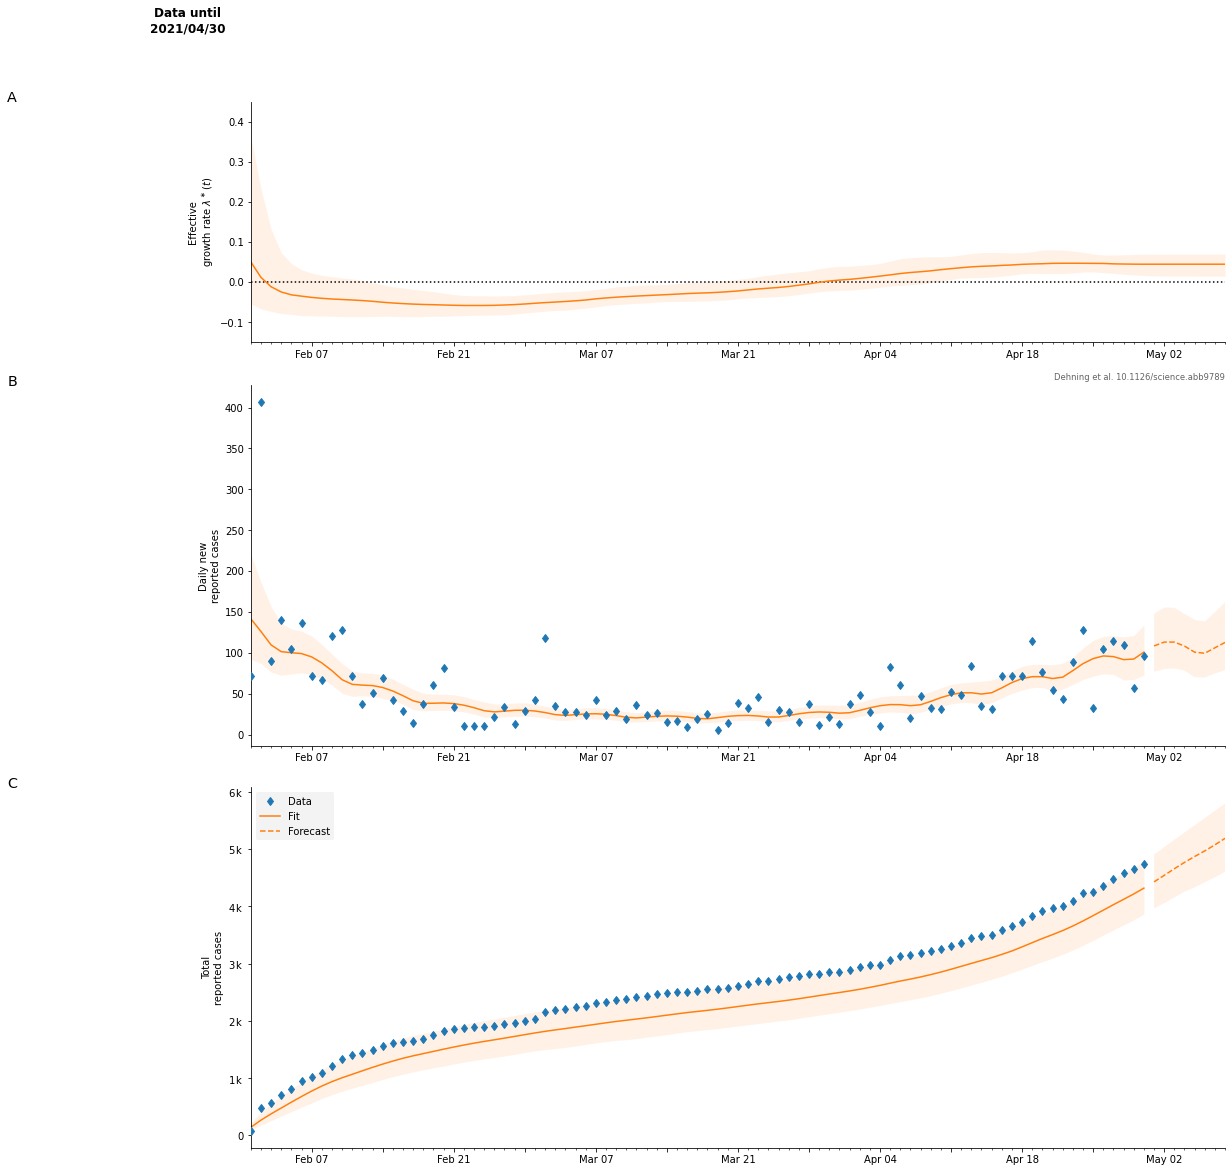

In [ ]:
cov19.plot.rcParams["color_model"] = "tab:orange"
fig, axes = cov19.plot.timeseries_overview(this_model, trace)
fig.set_size_inches(17,15)

In [ ]:
for ax in axes:
    ax.set_xlim(datetime.datetime.now() - datetime.timedelta(days=4 * 17))
# Set y lim for effective growth rate
axes[0].set_ylim(-0.1, 0.2)
axes[1].set_ylim(0, new_cases_obs.max() + 5000)

(0.0, 5407.0)

Text(-0.3, 1.1, 'F')

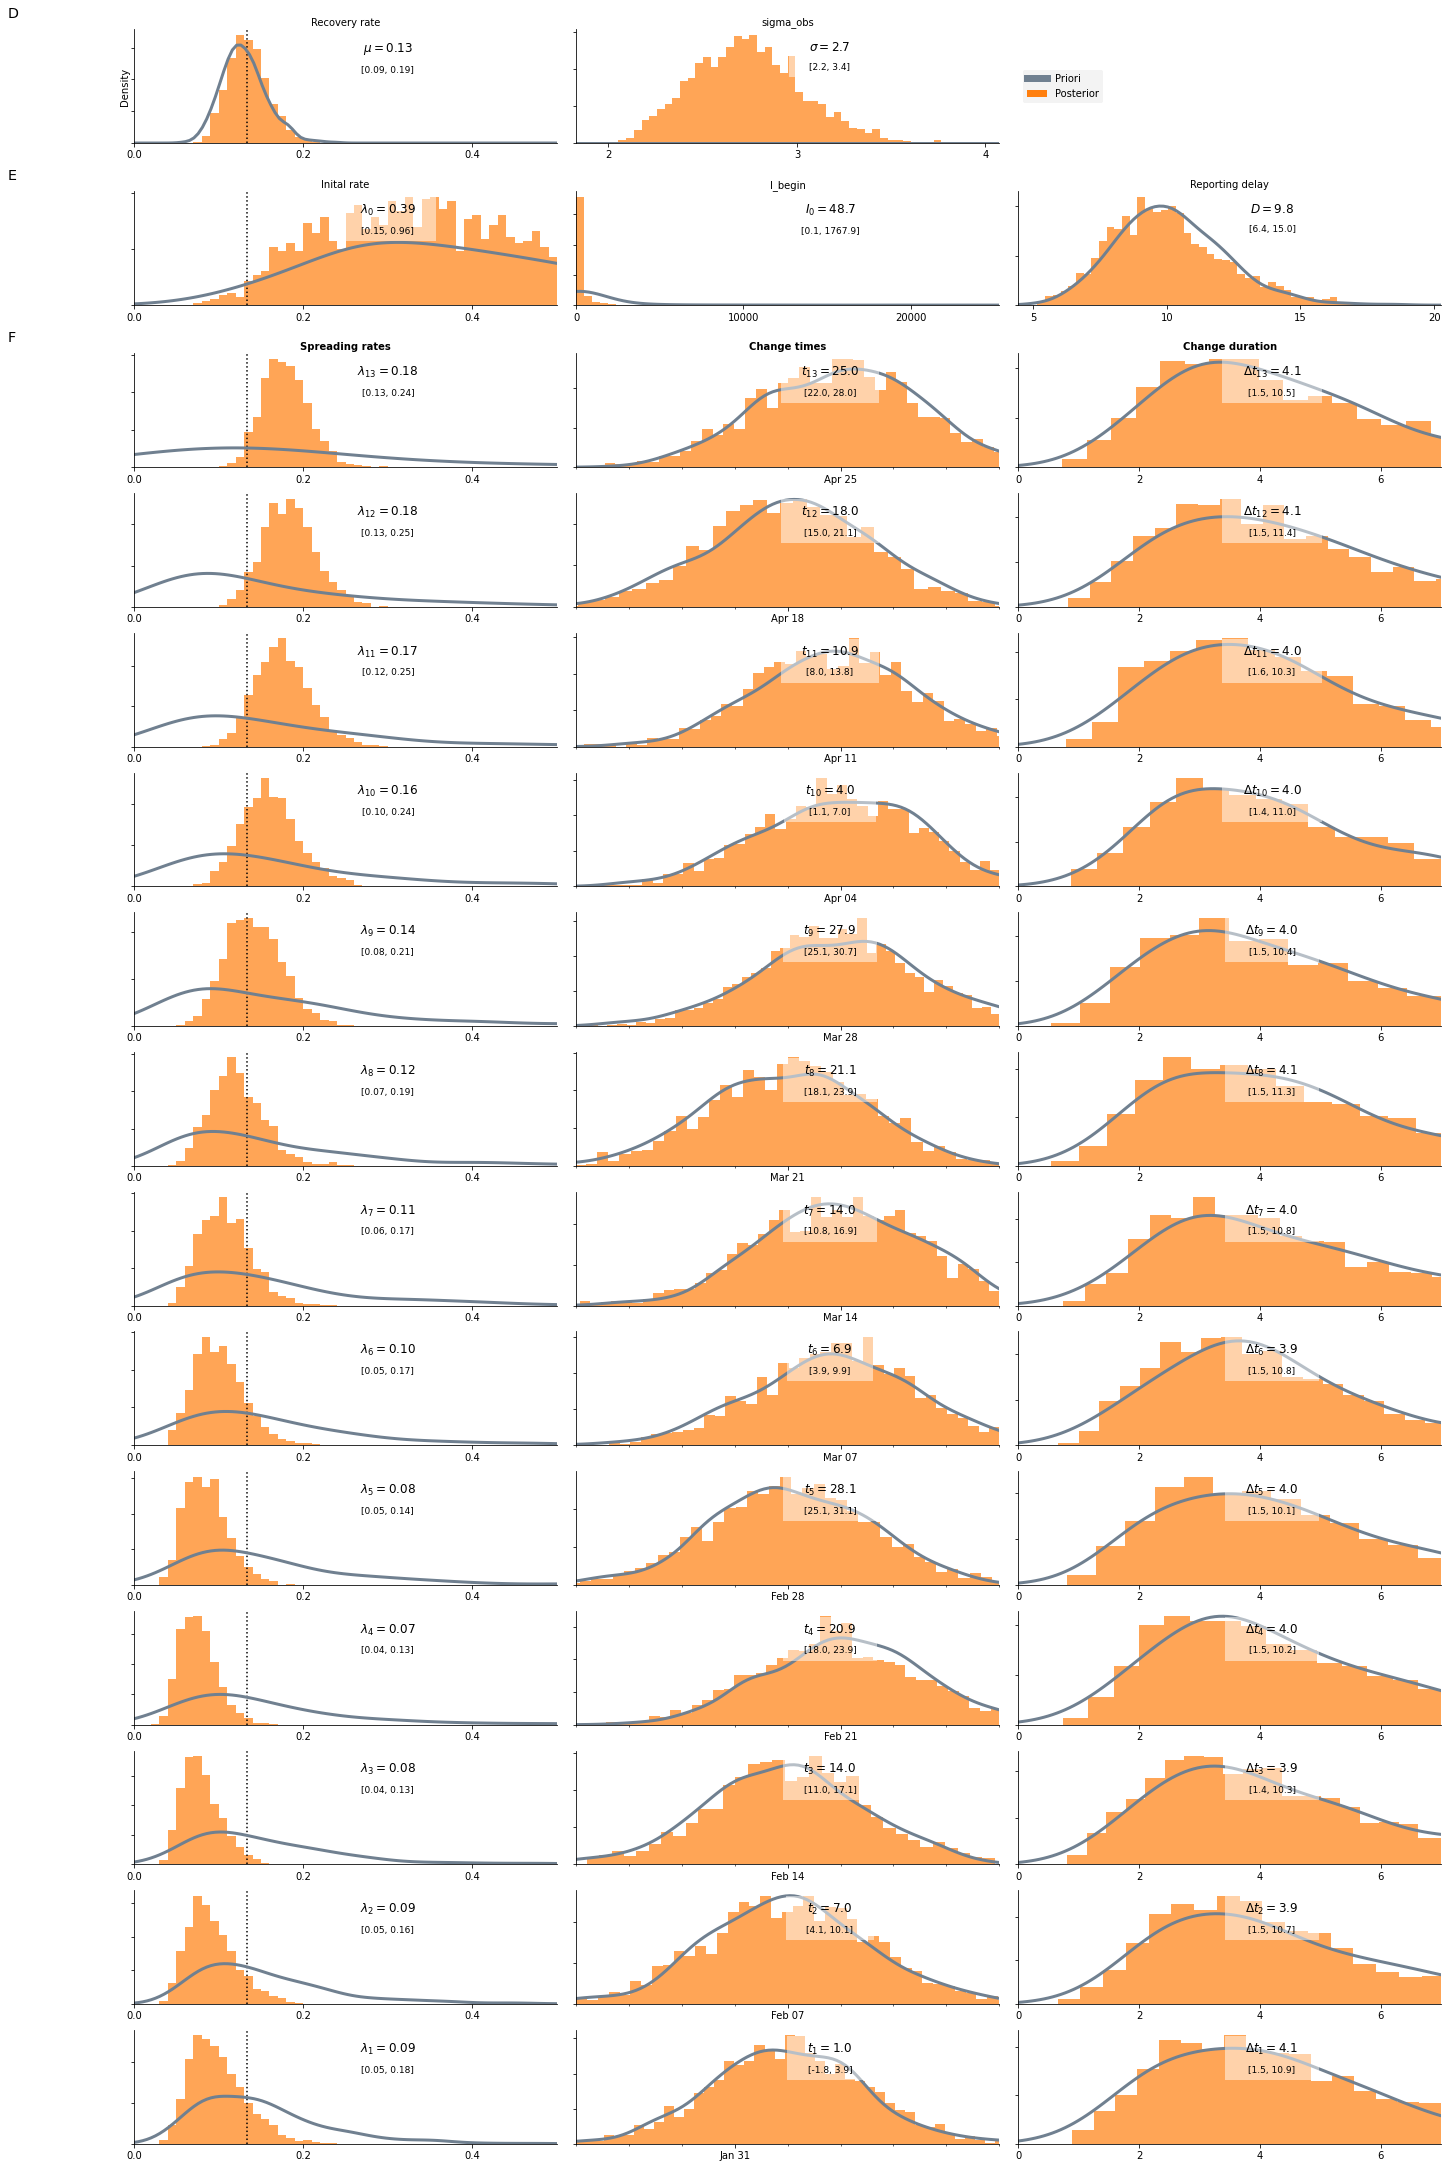

In [ ]:
num_rows = len(change_points) + 1 + 1
num_columns = int(np.ceil(14 / 5))
fig_width = 20
fig_height = 30
 
fig, axes = plt.subplots(
    15, num_columns, figsize=(fig_width, fig_height), constrained_layout=True
)
rows = [
    0,
    num_rows,
    num_rows - 1,
    num_rows - 2,
    num_rows - 3,
    num_rows - 4,
    num_rows - 5,
    num_rows - 6,
    num_rows - 7,
    num_rows - 8,
    num_rows - 9,
    num_rows - 10,
    num_rows - 11,
    num_rows - 12,
    num_rows - 13,
]
# Left row we want mu and all lambda_i!
for i in rows:
    if i == 0:
        cov19.plot._distribution(this_model, trace, "mu", axes[0, 0])
    elif i == num_rows:
        # Plot lambda_i and remove the xlable, we add one big label later.
        cov19.plot._distribution(this_model, trace, f"lambda_{0}", axes[1, 0])
        axes[1, 0].set_xlabel("Inital rate")
    else:
        # Plot lambda_i and remove the xlable, we add one big label later.
        cov19.plot._distribution(
            this_model, trace, f"lambda_{i-1}", axes[-i + num_rows + 1, 0]
        )
        axes[-i + num_rows + 1, 0].set_xlabel("")
# middle row
for i in rows:
    if i == 0:
        cov19.plot._distribution(this_model, trace, "sigma_obs", axes[i, 1])
    elif i == num_rows:
        cov19.plot._distribution(this_model, trace, "I_begin", axes[1, 1])
    else:
        # Plot transient_day_i and remove the xlable, we add one big label later.
        cov19.plot._distribution(
            this_model, trace, f"transient_day_{i-1}", axes[-i + num_rows + 1, 1]
        )
        axes[-i + num_rows + 1, 1].set_xlabel("")
# right row
for i in rows:
    if i == 0:
        # Create legend for everything
        axes[i, 2].set_axis_off()
        axes[i, 2].plot(
            [], [], color=cov19.plot.rcParams["color_prior"], linewidth=7, label="Priori"
        )
        axes[i, 2].hist([], color=cov19.plot.rcParams["color_model"], label="Posterior")
        axes[i, 2].legend(loc="center left")
        axes[i, 2].get_legend().get_frame().set_linewidth(0.0)
        axes[i, 2].get_legend().get_frame().set_facecolor("#F0F0F0")
    elif i == num_rows:
        cov19.plot._distribution(this_model, trace, f"delay", axes[1, 2])
        axes[1, 2].set_xlabel("Reporting delay")
    else:
        # Plot transient_len_i and remove the xlable, we add one big label later.
        cov19.plot._distribution(
            this_model, trace, f"transient_len_{i-1}", axes[-i + num_rows + 1, 2]
        )
        axes[-i + num_rows + 1, 2].set_xlabel("")
 
# Add ylabel for the first axes
axes[0, 0].set_ylabel("Density")
# Set bold xlabel for Spreading rates Change times and Change durations
axes[2, 0].set_xlabel("Spreading rates", fontweight="bold")
axes[2, 1].set_xlabel("Change times", fontweight="bold")
axes[2, 2].set_xlabel("Change duration", fontweight="bold")
 
# Letters
letter_kwargs = dict(x=-0.3, y=1.1, size="x-large")
axes[0, 0].text(s="D", transform=axes[0, 0].transAxes, **letter_kwargs)
axes[1, 0].text(s="E", transform=axes[1, 0].transAxes, **letter_kwargs)
axes[2, 0].text(s="F", transform=axes[2, 0].transAxes, **letter_kwargs)